In [1]:
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

engine = create_engine('sqlite:///db.sqlite')
connection = engine.connect()

request = "SELECT * FROM LostItem"
lost_item_df = pd.read_sql(request, connection, index_col="date")

# Convert index to datetime and temperature to float
lost_item_df.index = pd.to_datetime(lost_item_df.index,utc=True)
# GROUP BY DAY AND COUNT
lost_item_df_by_day = lost_item_df.groupby(lost_item_df.index.date).count()
lost_item_df_by_day = lost_item_df_by_day[["id"]].rename(columns={"id": "nb_lost_item"})
lost_item_df_by_day.index = pd.to_datetime(lost_item_df_by_day.index)
df = lost_item_df_by_day.loc["01-01-2021" :]

# Dummy model

In [2]:
df_ind = df.reset_index()
df_ind['year'] = [d.year for d in df_ind["index"]]
df_ind['month'] = [d.month for d in df_ind["index"]]
df_ind['week_day'] = [d.weekday() for d in df_ind["index"]]

In [3]:
####### Problème décrasement.


def xgboost_forecast(X,y):
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X):
        print(train_index)
        print(test_index)
        X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
        y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

    # Next, let's import and initialize the XGBoost model
    from xgboost import XGBRegressor

    model = XGBRegressor(base_score=0.5,n_estimators=1000, max_depth=3,
                       learning_rate=0.01,  objective='reg:linear')

    # Now, let's fit the model to the training data
    model.fit(X_train, y_train, verbose=100)

    # And finally, let's make predictions on the test set and evaluate the model
    print("test_score" , model.score(X_train,y_train))
    print("test_score" , model.score(X_test,y_test))

    print(model.feature_importances_)
    fi = pd.DataFrame(data=model.feature_importances_,
             index=X.columns,
             columns=['importance'])
    fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
    plt.show()

    y_test['prediction'] = model.predict(X_test)
    y = y.merge(y_test[['prediction']], how='left', left_index=True, right_index=True)
    ax = y[['nb_lost_item']].plot(figsize=(15, 5))
    y['prediction'].plot(ax=ax, style='.')
    plt.legend(['Truth Data', 'Predictions'])
    ax.set_title('Raw Dat and Prediction')
    plt.show()
   

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122]
[123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 240 241 242]
[  0   1   2

/usr/local/Caskroom/miniconda/base/envs/time_series/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/Caskroom/miniconda/base/envs/time_series/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:59:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
test_score 0.2876630435491657
test_score 0.0017459143563242074
[0.2484553  0.13187882 0.61966586]


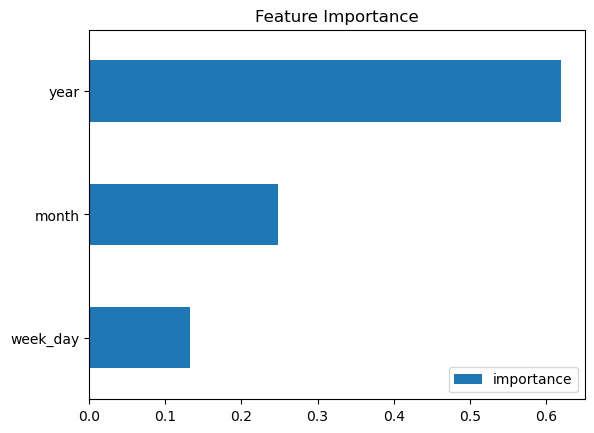

/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_18399/791155219.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['prediction'] = model.predict(X_test)


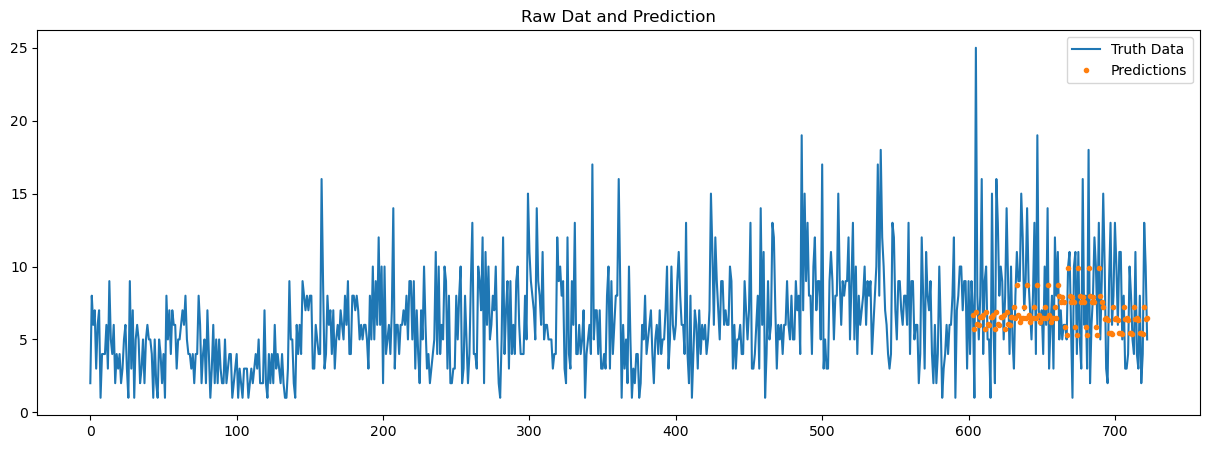

In [4]:
X = df_ind[["month","week_day","year"]]
y = df_ind[["nb_lost_item"]]

xgboost_forecast(X,y)

# Model avec des lags

In [70]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(df, n_in=3, n_out=1, dropnan=True):
	cols = []
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	column_name = []
	for i in range(n_in,0,-1):
		column_name.append(f"t-{i}")
	column_name.append("y")
	agg.columns = column_name

	return agg

In [71]:
df_lag = series_to_supervised(df["nb_lost_item"])

/usr/local/Caskroom/miniconda/base/envs/time_series/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:39:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
test_score 0.4388780538199931
test_score -0.2506740776432026
[0.32167983 0.23317446 0.11467782 0.12088281 0.12623528 0.08334982]


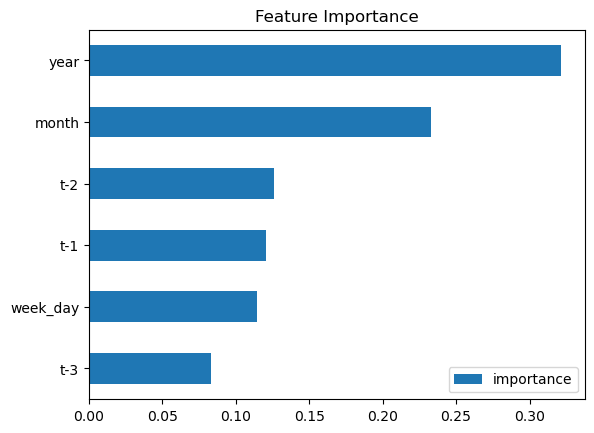

In [98]:
df_ind_lag = pd.concat([df_lag,df_ind],axis=1).dropna()

X = df_ind_lag[["year","month","week_day","t-1","t-2","t-3"]]
y = df_ind_lag["nb_lost_item"]

model_with_lag = xgboost_forecast(X,y)